In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.nn import DataParallel
from datetime import datetime
import torch.nn.init as init
import torch.nn as activation 
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn.functional import cosine_similarity
from datetime import datetime

In [2]:
class AugmentedDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.transform = transform
        self.image_filenames = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = self.image_filenames[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1, image2 = image, image
        
        return image1, image2

In [3]:
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=256),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
seed = 7
torch.manual_seed(seed)

folder_path = "/kaggle/input/manypets"
dataset = AugmentedDataset(folder_path=folder_path, transform=contrast_transforms)

# Разделение на тренировочную и тестовую выборку (например, 80% на тренировочную, 20% на тестовую)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Создание DataLoader для тренировочной и тестовой выборки
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [5]:
def replace_layers(act, model, old):
    if isinstance(act, str):
        if act != 'Default':
            new = getattr(activation, act)
            _replace_layers(model, old, new())
    else:
        train_act_name = act['name']
        train_act_acts = act['activations']
        acts = _get_acts(train_act_acts)

        new = getattr(activation, train_act_name)
        _replace_layers(model, old, new(activations=acts))


def _replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            _replace_layers(module, old, new)

        if isinstance(module, old):
            setattr(model, n, new)


def _weights_init_cifar(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


def _get_acts(train_act_acts):
    acts = []

    for act_name in train_act_acts:
        acts.append(getattr(F, act_name))

    return acts


class LambdaLayerCifar(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayerCifar, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlockCifar(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlockCifar, self).__init__()

        self.conv1 = nn.Conv2d(
            in_planes,
            planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )

        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )

        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        if stride != 1 or in_planes != planes:
            if option == 'A':
                tup1 = (0, 0, 0, 0, planes // 4, planes // 4)
                def f(x): return F.pad(x[:, :, ::2, ::2], tup1, 'constant', 0)
                self.shortcut = LambdaLayerCifar(f)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) 
        out = self.relu(out)
        return out


class ResNetCifar(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetCifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(
            3,
            16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )

        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.fc = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.apply(_weights_init_cifar)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class ResNet14(nn.Module):
    def __init__(self, params):
        super().__init__()

        in_channels = params['in_channels']
        out_channels = params['out_channels']

        train_act = params['activation']

        self.model = ResNetCifar(BasicBlockCifar, [2, 2, 2])

        self.model.conv1 = nn.Conv2d(
            in_channels,
            16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )

        self.model.fc = nn.Linear(64, out_channels, bias=True)
        replace_layers(train_act, self.model, nn.ReLU)

    def forward(self, x):
        out = self.model(x)
        return out

In [6]:
class SimCLR(nn.Module):
    def __init__(self, params, pretrained_weights_path=None):
        super(SimCLR, self).__init__()
        self.backbone = self._init_backbone(params, pretrained_weights_path)
        self.projection_head = self._init_projection_head(params)

    def forward(self, x):
        h = self.backbone(x)
        z = self.projection_head(h)
        z_normalized = F.normalize(z, dim=1)
        return z_normalized

    def _init_backbone(self, params, pretrained_weights_path):
        backbone = ResNet14(params)
        if pretrained_weights_path:
            # Загрузка предобученных весов, если файл предоставлен
            pretrained_dict = torch.load(pretrained_weights_path, map_location='cpu')
            model_dict = backbone.state_dict()
            # Фильтрация весов, которые существуют и совпадают по размеру
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].size() == v.size()}
            model_dict.update(pretrained_dict)
            backbone.load_state_dict(model_dict)
        return backbone

    def _init_projection_head(self, params):
        # Инициализация проекционного слоя
        projection_head = nn.Sequential(
            nn.Linear(params['out_channels'], params['projection_dim']),
            nn.ReLU(inplace=True),
            nn.Linear(params['projection_dim'], params['projection_dim']),
            nn.ReLU(inplace=True)
        )
        return projection_head

In [7]:
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(InfoNCELoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, z_i, z_j):
        # Batch size
        batch_size = z_i.size(0)

        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        # Create positive pairs
        pos_sim = self.cosine_similarity(z_i, z_j)

        # Create labels for positive pairs (1 for positive samples, 0 for negative)
        labels = torch.cat([torch.ones(batch_size), torch.zeros(batch_size)], dim=0).to(z_i.device)

        # Create the similarity matrix for all samples
        sim_matrix = torch.cat([z_i, z_j], dim=0)
        sim_matrix = torch.mm(sim_matrix, sim_matrix.t())

        # Mask to remove self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z_i.device)
        sim_matrix = sim_matrix[~mask].view(2 * batch_size, -1)

        # Compute logits
        logits = sim_matrix / self.temperature

        # Create positive pair similarities for the loss
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

        # Calculate InfoNCE loss
        loss = -torch.log(torch.exp(pos_sim / self.temperature) / torch.sum(torch.exp(logits), dim=1)).mean()

        return loss

In [8]:
def train_simclr(model, train_loader, test_loader, optimizer, criterion, scheduler, device, num_epochs, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    train_losses = []
    test_losses = []
    train_cos_sim_positives = []
    test_cos_sim_positives = []
    train_cos_sim_negatives = []
    test_cos_sim_negatives = []
    accuracies = []
    test_accuracies = []

    plt.ion()  # Interactive mode on

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch: {epoch + 1}, start {datetime.now()}')
        total_train_loss = 0.0
        total_test_loss = 0.0
        total_train_pos_sim = 0.0
        total_train_neg_sim = 0.0
        total_test_pos_sim = 0.0
        total_test_neg_sim = 0.0
        total_accuracy = 0.0
        total_test_accuracy = 0.0

        # Обучение
        model.train()
        for i, (images1, images2) in enumerate(train_loader, 1):
            images1 = images1.to(device)
            images2 = images2.to(device)

            optimizer.zero_grad()

            outputs1 = model(images1)
            outputs2 = model(images2)

            loss = criterion(outputs1, outputs2)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            # Косинусное сходство для положительных пар (для всего батча)
            pos_sim = F.cosine_similarity(outputs1, outputs2, dim=-1)  # Тензор размером [batch_size]

            # Создание отрицательных пар: сдвигаем второй тензор случайно
            rand_idx = torch.randperm(outputs1.size(0))
            neg_sim = F.cosine_similarity(outputs1, outputs2[rand_idx], dim=-1)  # Тензор размером [batch_size]

            # Accuracy: проверяем для всех элементов батча, правильно ли положительные примеры ближе отрицательных
            correct = (pos_sim > neg_sim).float()  # Тензор [batch_size] с 0 или 1
            accuracy = correct.mean().item()  # Среднее значение по батчу

            total_accuracy += accuracy

            # Очистка кэша после каждого батча
            torch.cuda.empty_cache()

        average_train_loss = total_train_loss / len(train_loader)

        train_losses.append(average_train_loss)

        accuracies.append(total_accuracy / len(train_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Accuracy: {total_accuracy / len(train_loader):.4f}")

        # Валидация
        model.eval()
        with torch.no_grad():
            for images1, images2 in test_loader:
                images1 = images1.to(device)
                images2 = images2.to(device)

                outputs1 = model(images1)
                outputs2 = model(images2)

                loss = criterion(outputs1, outputs2)
                total_test_loss += loss.item()

                # Косинусное сходство для положительных пар
                pos_sim = F.cosine_similarity(outputs1, outputs2, dim=-1)  # Тензор размером [batch_size]
                total_test_pos_sim += pos_sim.mean().item()

                # Отрицательные пары
                rand_idx = torch.randperm(outputs1.size(0))
                neg_sim = F.cosine_similarity(outputs1, outputs2[rand_idx], dim=-1)  # Тензор размером [batch_size]
                total_test_neg_sim += neg_sim.mean().item()

                # Accuracy: проверяем для всех элементов батча
                correct = (pos_sim > neg_sim).float()
                test_accuracy = correct.mean().item()
                total_test_accuracy += test_accuracy

                # Очистка кэша после каждого батча
                torch.cuda.empty_cache()

        test_accuracies.append(total_test_accuracy / len(test_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {total_test_accuracy / len(test_loader):.4f}")
        print(f'Epoch: {epoch + 1}, end {datetime.now()}')

        # Обновление графика потерь на каждую эпоху
        plt.cla()
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.plot(accuracies, label='Train Accuracy')
        plt.plot(test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Loss / Accuracy')
        plt.title('Train and Test Losses and Accuracy')
        plt.legend()
        plt.draw()
        plt.pause(0.001)

        # Сохранение весов модели с пометкой номера эпохи
        save_path = os.path.join(save_dir, f"simclr_epoch_{epoch+1}_top_accuracy_{total_test_accuracy / len(test_loader):.4f}.pth")
        torch.save(model.state_dict(), save_path)

        # Шаг scheduler
        scheduler.step()

        # Очистка кэша после каждой эпохи
        torch.cuda.empty_cache()

    plt.ioff()  # Interactive mode off
    plt.show()  # Final display of the plot
    print("Обучение окончено")


Using 2 GPUs!


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, start 2024-10-14 14:16:45.430335
Epoch [1/30], Train Loss: 5.4496, Accuracy: 0.6548
Epoch [1/30], Test Accuracy: 0.6750
Epoch: 1, end 2024-10-14 14:23:24.639337


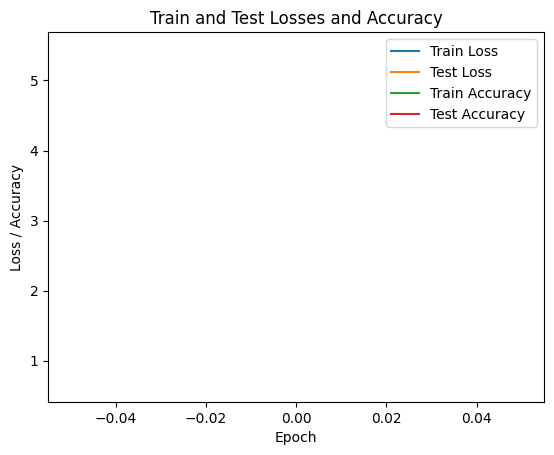

  3%|▎         | 1/30 [06:39<3:13:08, 399.60s/it]

Epoch: 2, start 2024-10-14 14:23:25.028911
Epoch [2/30], Train Loss: 5.3540, Accuracy: 0.6993
Epoch [2/30], Test Accuracy: 0.7090
Epoch: 2, end 2024-10-14 14:29:44.357637


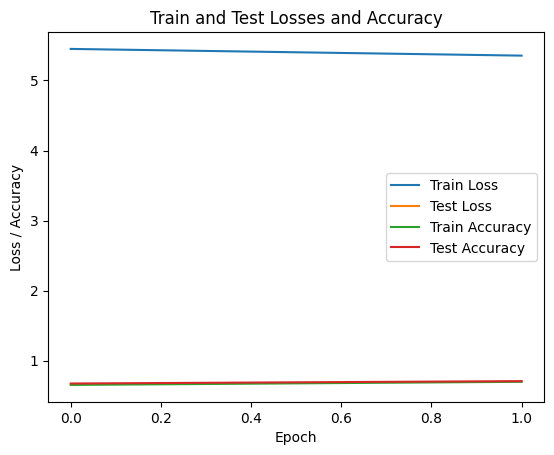

  7%|▋         | 2/30 [12:59<3:01:01, 387.90s/it]

Epoch: 3, start 2024-10-14 14:29:44.734380
Epoch [3/30], Train Loss: 5.2701, Accuracy: 0.7308
Epoch [3/30], Test Accuracy: 0.7589
Epoch: 3, end 2024-10-14 14:35:57.432638


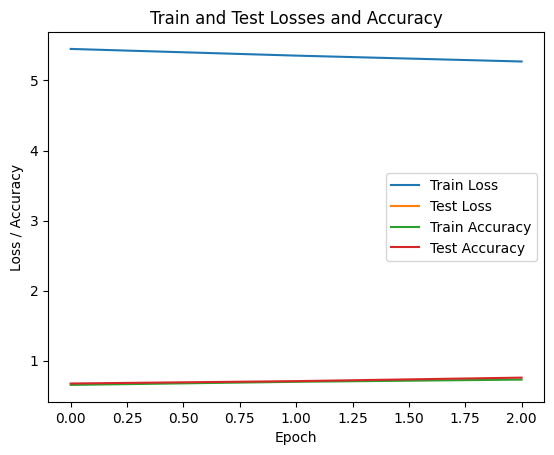

 10%|█         | 3/30 [19:12<2:51:30, 381.13s/it]

Epoch: 4, start 2024-10-14 14:35:57.821775
Epoch [4/30], Train Loss: 5.2028, Accuracy: 0.7519
Epoch [4/30], Test Accuracy: 0.7596
Epoch: 4, end 2024-10-14 14:42:10.895978


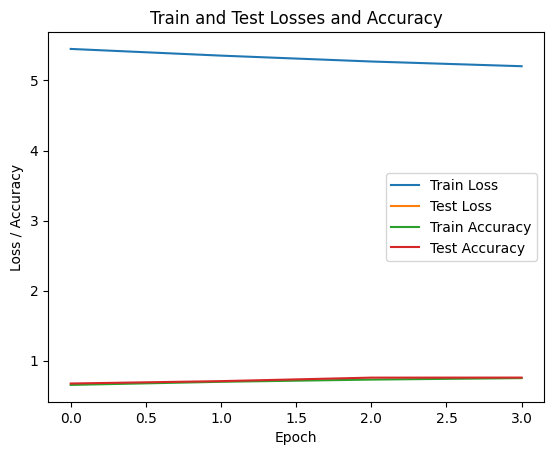

 13%|█▎        | 4/30 [25:25<2:43:50, 378.10s/it]

Epoch: 5, start 2024-10-14 14:42:11.280661
Epoch [5/30], Train Loss: 5.1448, Accuracy: 0.7716
Epoch [5/30], Test Accuracy: 0.7934
Epoch: 5, end 2024-10-14 14:48:31.817851


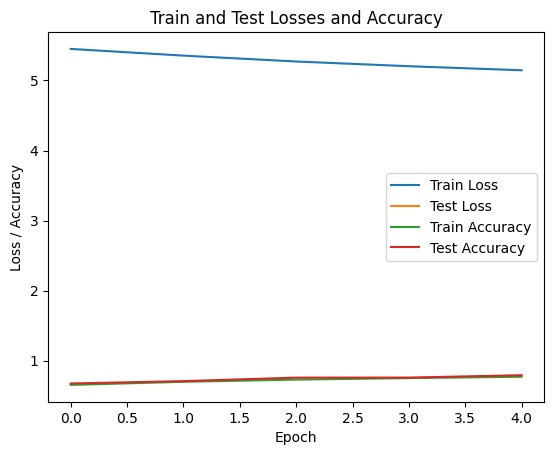

 17%|█▋        | 5/30 [31:46<2:37:58, 379.12s/it]

Epoch: 6, start 2024-10-14 14:48:32.203076
Epoch [6/30], Train Loss: 5.1133, Accuracy: 0.7747
Epoch [6/30], Test Accuracy: 0.7889
Epoch: 6, end 2024-10-14 14:54:48.263276


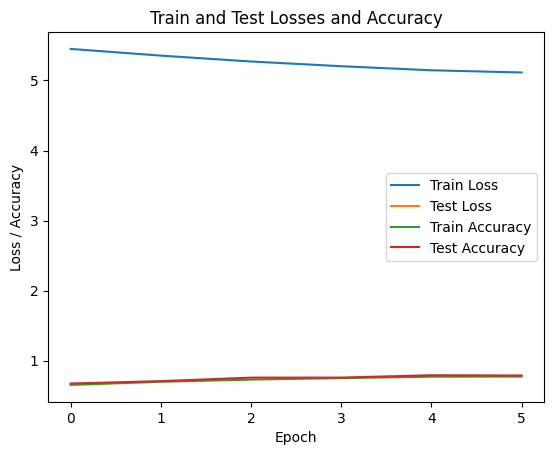

 20%|██        | 6/30 [38:03<2:31:16, 378.20s/it]

Epoch: 7, start 2024-10-14 14:54:48.622444
Epoch [7/30], Train Loss: 5.0853, Accuracy: 0.7899
Epoch [7/30], Test Accuracy: 0.7972
Epoch: 7, end 2024-10-14 15:01:02.548378


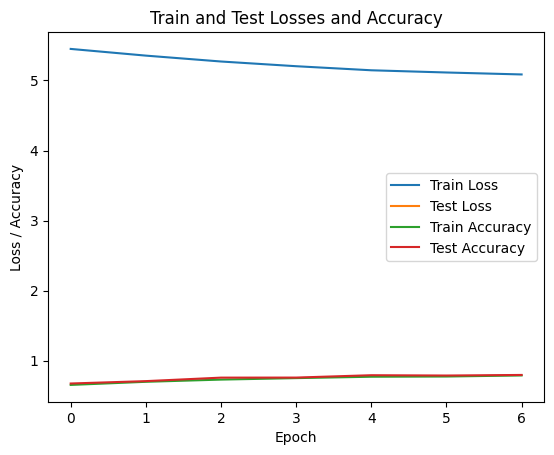

 23%|██▎       | 7/30 [44:17<2:24:29, 376.93s/it]

Epoch: 8, start 2024-10-14 15:01:02.947651
Epoch [8/30], Train Loss: 5.0671, Accuracy: 0.7890
Epoch [8/30], Test Accuracy: 0.8104
Epoch: 8, end 2024-10-14 15:07:17.642345


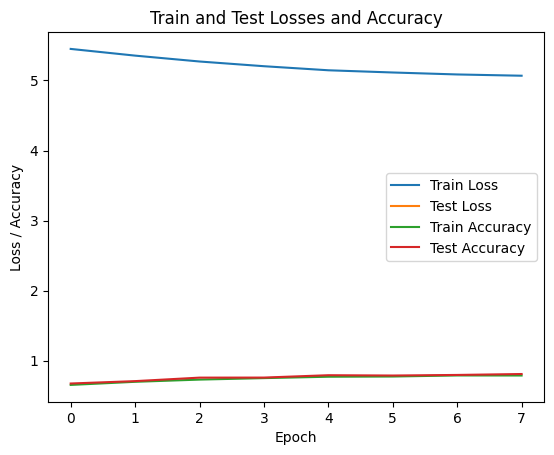

 27%|██▋       | 8/30 [50:32<2:17:59, 376.35s/it]

Epoch: 9, start 2024-10-14 15:07:18.050986
Epoch [9/30], Train Loss: 5.0543, Accuracy: 0.7947
Epoch [9/30], Test Accuracy: 0.8050
Epoch: 9, end 2024-10-14 15:13:29.840133


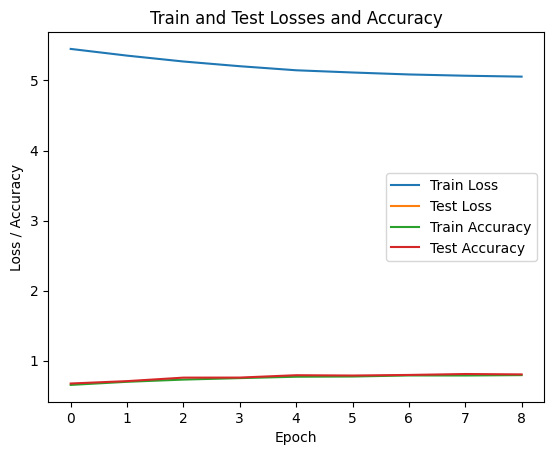

 30%|███       | 9/30 [56:44<2:11:15, 375.05s/it]

Epoch: 10, start 2024-10-14 15:13:30.230962
Epoch [10/30], Train Loss: 5.0396, Accuracy: 0.7991
Epoch [10/30], Test Accuracy: 0.8122
Epoch: 10, end 2024-10-14 15:19:40.303747


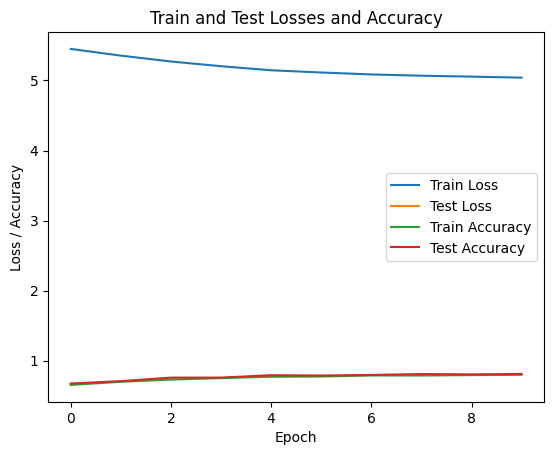

 33%|███▎      | 10/30 [1:02:55<2:04:32, 373.62s/it]

Epoch: 11, start 2024-10-14 15:19:40.662357
Epoch [11/30], Train Loss: 5.0402, Accuracy: 0.7943
Epoch [11/30], Test Accuracy: 0.8120
Epoch: 11, end 2024-10-14 15:25:54.597924


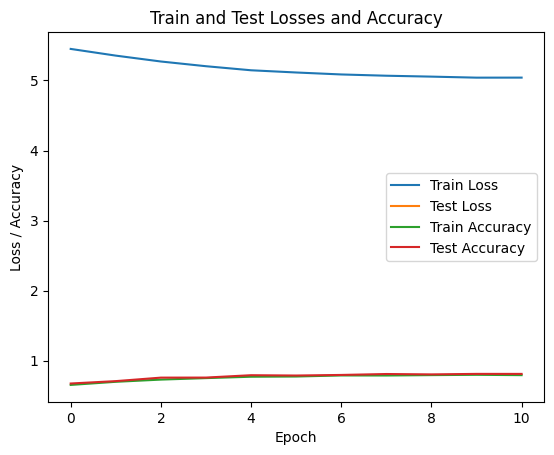

 37%|███▋      | 11/30 [1:09:09<1:58:22, 373.83s/it]

Epoch: 12, start 2024-10-14 15:25:54.969868
Epoch [12/30], Train Loss: 5.0295, Accuracy: 0.8027
Epoch [12/30], Test Accuracy: 0.8233
Epoch: 12, end 2024-10-14 15:32:14.410915


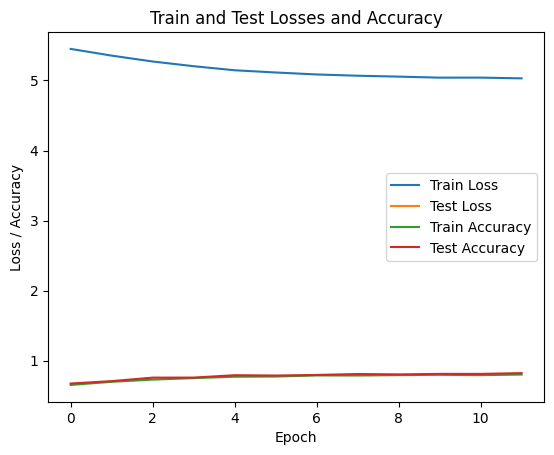

 40%|████      | 12/30 [1:15:29<1:52:41, 375.65s/it]

Epoch: 13, start 2024-10-14 15:32:14.777204
Epoch [13/30], Train Loss: 5.0229, Accuracy: 0.8023
Epoch [13/30], Test Accuracy: 0.8151
Epoch: 13, end 2024-10-14 15:38:36.121970


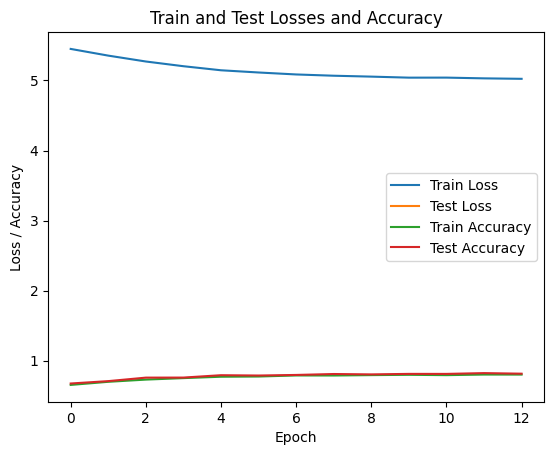

 43%|████▎     | 13/30 [1:21:51<1:46:57, 377.50s/it]

Epoch: 14, start 2024-10-14 15:38:36.520551
Epoch [14/30], Train Loss: 5.0210, Accuracy: 0.8022
Epoch [14/30], Test Accuracy: 0.8139
Epoch: 14, end 2024-10-14 15:44:50.255283


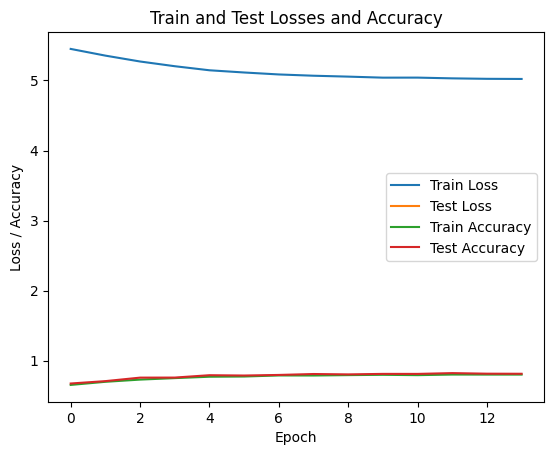

 47%|████▋     | 14/30 [1:28:05<1:40:23, 376.47s/it]

Epoch: 15, start 2024-10-14 15:44:50.625937
Epoch [15/30], Train Loss: 5.0104, Accuracy: 0.8090
Epoch [15/30], Test Accuracy: 0.8210
Epoch: 15, end 2024-10-14 15:51:08.647312


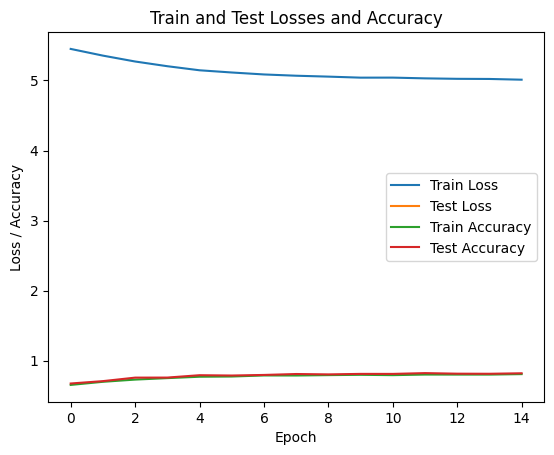

 50%|█████     | 15/30 [1:34:23<1:34:15, 377.05s/it]

Epoch: 16, start 2024-10-14 15:51:09.022813
Epoch [16/30], Train Loss: 5.0119, Accuracy: 0.8111
Epoch [16/30], Test Accuracy: 0.8034
Epoch: 16, end 2024-10-14 15:57:23.441294


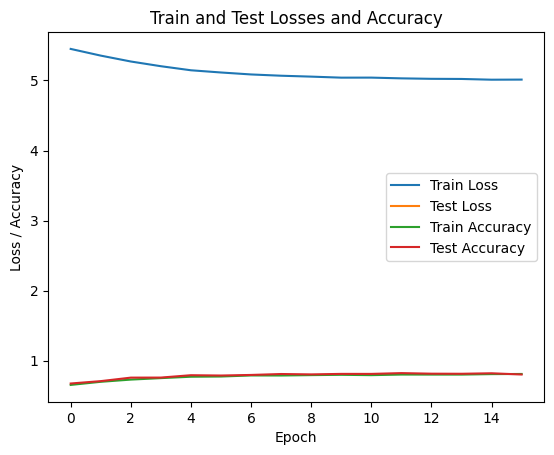

 53%|█████▎    | 16/30 [1:40:38<1:27:49, 376.37s/it]

Epoch: 17, start 2024-10-14 15:57:23.817953
Epoch [17/30], Train Loss: 5.0051, Accuracy: 0.8067
Epoch [17/30], Test Accuracy: 0.8155
Epoch: 17, end 2024-10-14 16:03:41.185424


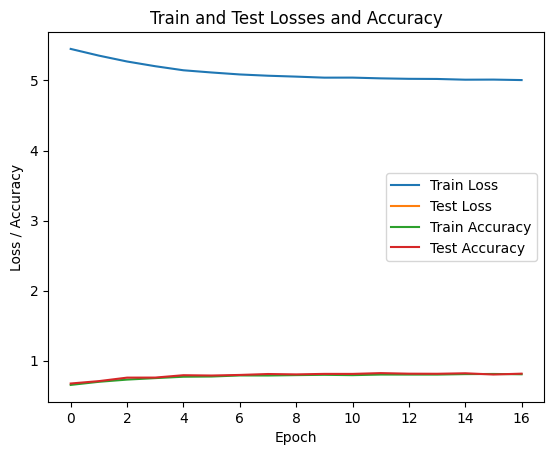

 57%|█████▋    | 17/30 [1:46:56<1:21:38, 376.79s/it]

Epoch: 18, start 2024-10-14 16:03:41.573615
Epoch [18/30], Train Loss: 5.0075, Accuracy: 0.8086
Epoch [18/30], Test Accuracy: 0.8094
Epoch: 18, end 2024-10-14 16:09:56.313835


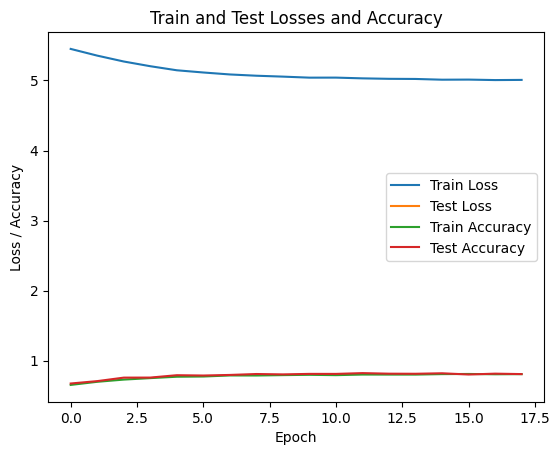

 60%|██████    | 18/30 [1:53:11<1:15:16, 376.35s/it]

Epoch: 19, start 2024-10-14 16:09:56.903836
Epoch [19/30], Train Loss: 4.9988, Accuracy: 0.8064
Epoch [19/30], Test Accuracy: 0.8144
Epoch: 19, end 2024-10-14 16:16:22.860514


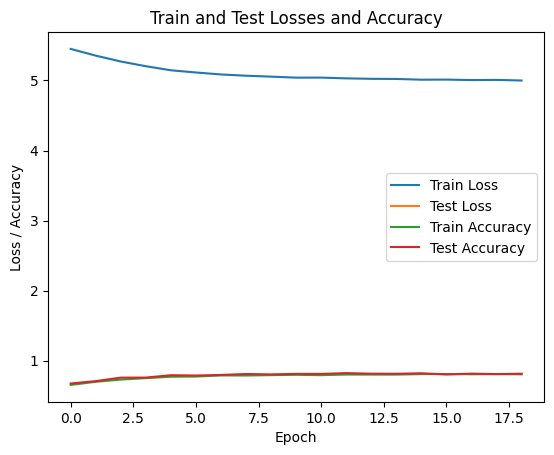

 63%|██████▎   | 19/30 [1:59:37<1:09:32, 379.35s/it]

Epoch: 20, start 2024-10-14 16:16:23.244945
Epoch [20/30], Train Loss: 4.9912, Accuracy: 0.8107
Epoch [20/30], Test Accuracy: 0.8069
Epoch: 20, end 2024-10-14 16:22:43.185697


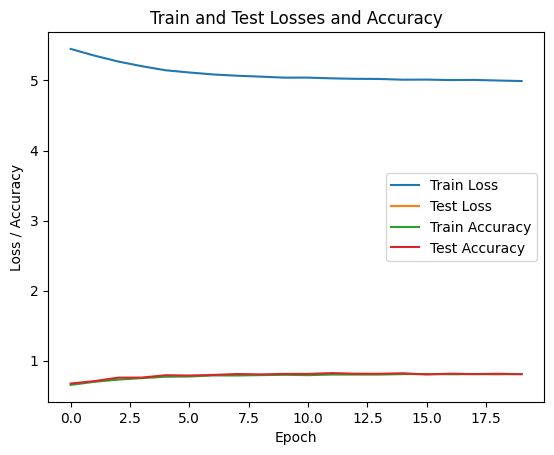

 67%|██████▋   | 20/30 [2:05:58<1:03:16, 379.64s/it]

Epoch: 21, start 2024-10-14 16:22:43.564321
Epoch [21/30], Train Loss: 5.0051, Accuracy: 0.8059
Epoch [21/30], Test Accuracy: 0.8203
Epoch: 21, end 2024-10-14 16:29:00.865638


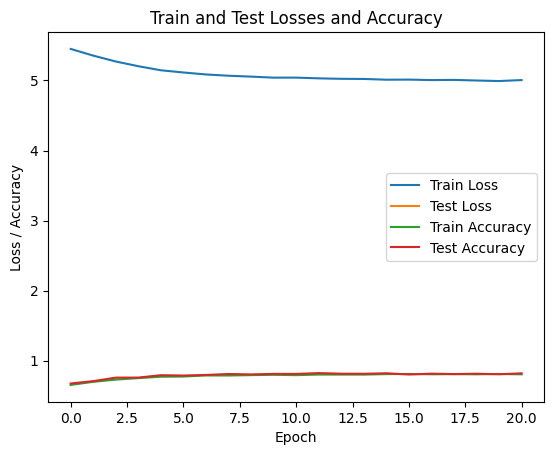

 70%|███████   | 21/30 [2:12:15<56:51, 379.06s/it]  

Epoch: 22, start 2024-10-14 16:29:01.270596
Epoch [22/30], Train Loss: 4.9965, Accuracy: 0.8112
Epoch [22/30], Test Accuracy: 0.8215
Epoch: 22, end 2024-10-14 16:35:15.486175


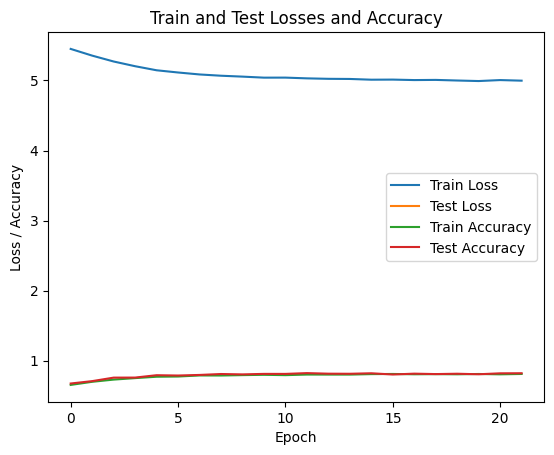

 73%|███████▎  | 22/30 [2:18:30<50:21, 377.72s/it]

Epoch: 23, start 2024-10-14 16:35:15.851835
Epoch [23/30], Train Loss: 4.9967, Accuracy: 0.8053
Epoch [23/30], Test Accuracy: 0.8045
Epoch: 23, end 2024-10-14 16:41:29.195678


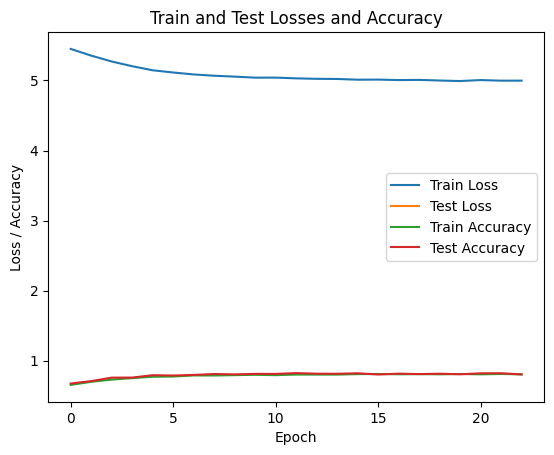

 77%|███████▋  | 23/30 [2:24:44<43:55, 376.51s/it]

Epoch: 24, start 2024-10-14 16:41:29.558971
Epoch [24/30], Train Loss: 4.9979, Accuracy: 0.8091
Epoch [24/30], Test Accuracy: 0.8209
Epoch: 24, end 2024-10-14 16:47:43.287315


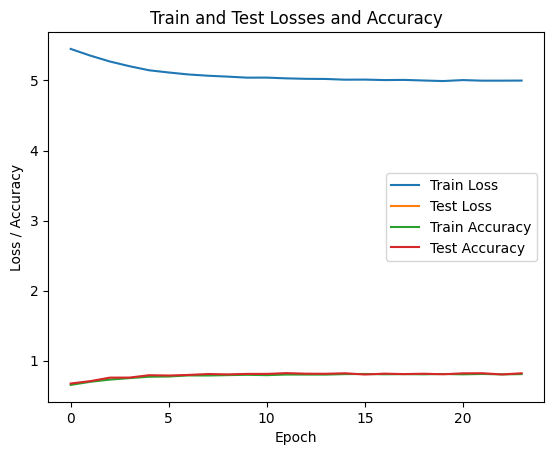

 80%|████████  | 24/30 [2:30:58<37:34, 375.79s/it]

Epoch: 25, start 2024-10-14 16:47:43.645562
Epoch [25/30], Train Loss: 4.9900, Accuracy: 0.8134
Epoch [25/30], Test Accuracy: 0.8204
Epoch: 25, end 2024-10-14 16:53:52.888544


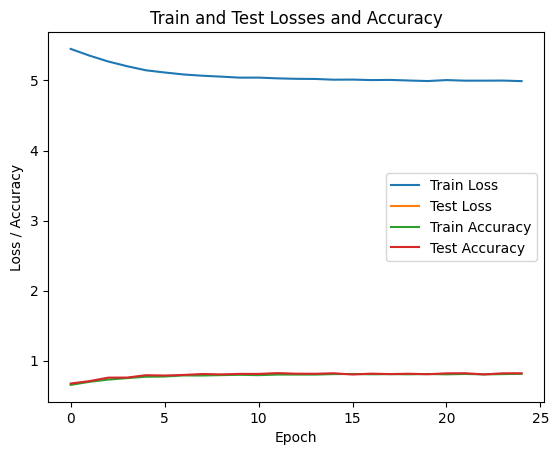

 83%|████████▎ | 25/30 [2:37:07<31:09, 373.93s/it]

Epoch: 26, start 2024-10-14 16:53:53.247137
Epoch [26/30], Train Loss: 4.9955, Accuracy: 0.8143
Epoch [26/30], Test Accuracy: 0.8303
Epoch: 26, end 2024-10-14 17:00:07.656334


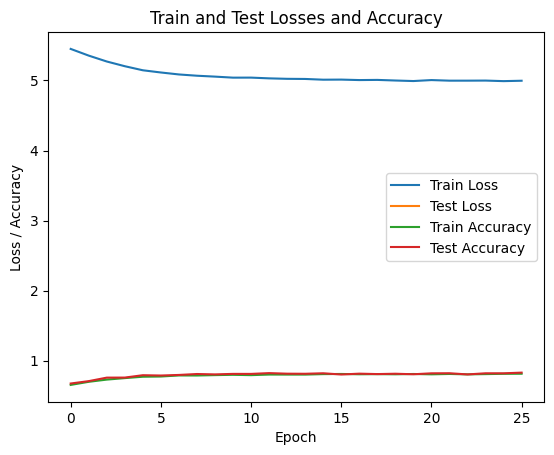

 87%|████████▋ | 26/30 [2:43:22<24:56, 374.18s/it]

Epoch: 27, start 2024-10-14 17:00:08.018457
Epoch [27/30], Train Loss: 4.9898, Accuracy: 0.8179
Epoch [27/30], Test Accuracy: 0.8158
Epoch: 27, end 2024-10-14 17:06:20.248204


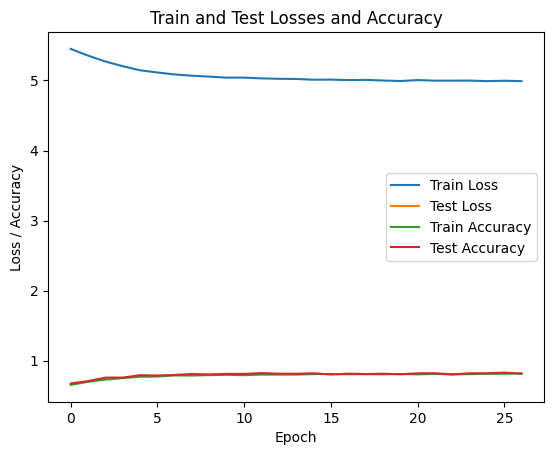

 90%|█████████ | 27/30 [2:49:35<18:41, 373.71s/it]

Epoch: 28, start 2024-10-14 17:06:20.618498
Epoch [28/30], Train Loss: 4.9926, Accuracy: 0.8181
Epoch [28/30], Test Accuracy: 0.8076
Epoch: 28, end 2024-10-14 17:12:36.918165


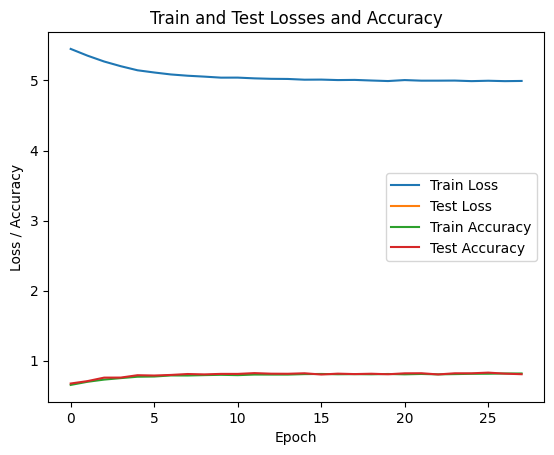

 93%|█████████▎| 28/30 [2:55:51<12:29, 374.60s/it]

Epoch: 29, start 2024-10-14 17:12:37.316132
Epoch [29/30], Train Loss: 4.9927, Accuracy: 0.8134
Epoch [29/30], Test Accuracy: 0.8256
Epoch: 29, end 2024-10-14 17:18:59.325699


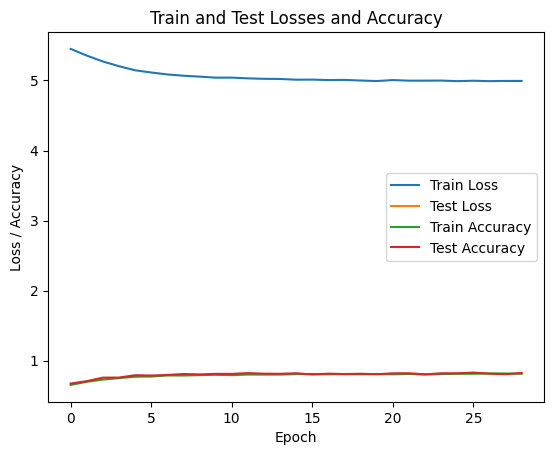

 97%|█████████▋| 29/30 [3:02:14<06:16, 376.94s/it]

Epoch: 30, start 2024-10-14 17:18:59.703832
Epoch [30/30], Train Loss: 4.9879, Accuracy: 0.8170
Epoch [30/30], Test Accuracy: 0.8065
Epoch: 30, end 2024-10-14 17:25:15.405629


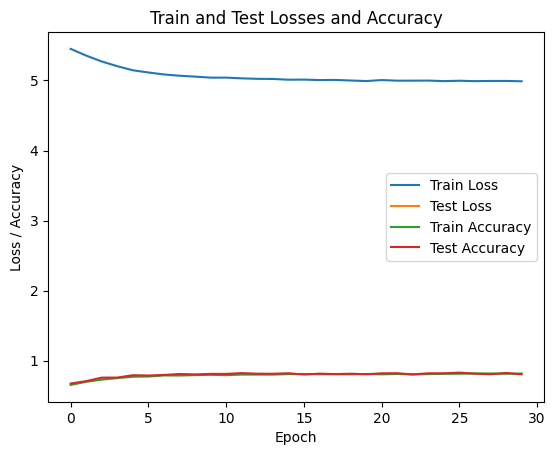

100%|██████████| 30/30 [3:08:30<00:00, 377.01s/it]

Обучение окончено


In [9]:
weight_path = "/kaggle/input/resnet-weights/ep90_lv0.37.pth"

params = {
    'in_channels': 3,
    'out_channels': 64,
    'projection_dim': 64,  # Установка размерности проекции в 64
    'activation': 'Default'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR(params, weight_path).to(device)

# Использование DataParallel для распределения обучения на нескольких GPU
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# Оптимизатор и критерий
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = InfoNCELoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

train_simclr(model, train_loader, test_loader, optimizer, criterion, scheduler, device, num_epochs=30, save_dir='simclr_weights')

In [11]:
from collections import OrderedDict

weight_path_simclr = "/kaggle/input/simclr-ep30/simclr_epoch_30_top_accuracy_0.8065.pth"
weight_path_resnet14 = "/kaggle/input/resnet-weights/ep90_lv0.37.pth"

params = {
    'in_channels': 3,
    'out_channels': 64,
    'projection_dim': 64,  
    'activation': 'Default'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR(params, weight_path_resnet14).to(device)

simclr_state_dict = torch.load(weight_path_simclr)
new_simclr_state_dict = OrderedDict()
for k, v in simclr_state_dict.items():
    name = k[7:] if k.startswith('module.') else k
    new_simclr_state_dict[name] = v

model.load_state_dict(new_simclr_state_dict, strict=False)

<All keys matched successfully>

In [12]:
model.eval()

for i, (images1, images2) in tqdm(enumerate(train_loader, 1)):
    print(i)
    images1 = images1.to(device)
    images2 = images2.to(device)


    with torch.no_grad():
        print(images1.shape)
        outputs1 = model(images1)
        print(outputs1)
        
    break

0it [00:00, ?it/s]

1
torch.Size([128, 3, 256, 256])


0it [00:07, ?it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3253],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2426, 0.0430, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2013, 0.5076, 0.0000,  ..., 0.0000, 0.0000, 0.1259],
        [0.0000, 0.3811, 0.0000,  ..., 0.0000, 0.0000, 0.1324]],
       device='cuda:0')


In [15]:
def test(model, loader, device, test_size=5):
    model.eval()
    results = []
    total_deviation = 0

    for run in tqdm(range(test_size)):
        with torch.no_grad():
            for i, (images1, images2) in tqdm(enumerate(loader, 1)):
                images1 = images1.to(device)
                images2 = images2.to(device)

               
                embeddings1 = model(images1)
                embeddings2 = model(images2)

                
                base_embedding = embeddings1[0].unsqueeze(0)

             
                similarities = []
                for j, embedding in enumerate(embeddings2):
                    embedding = embedding.unsqueeze(0)
                    cosine_similarity = F.cosine_similarity(base_embedding, embedding, dim=1).item()
                    is_original = 1 if j == 0 else 0  #

                    results.append([run, i, j, cosine_similarity, is_original])
                    similarities.append((cosine_similarity, is_original))

               
                similarities.sort(key=lambda x: x[0], reverse=True)
                for rank, (similarity, is_original) in enumerate(similarities):
                    if is_original:
                        total_deviation += rank
                        break

                break  


    df = pd.DataFrame(results, columns=['Run', 'Batch_Index', 'Image2_Index', 'Cosine_Similarity', 'Is_Original'])
    
    
    mean_deviation = total_deviation / test_size
    accuracy = 1 - (mean_deviation / len(images2))  

    return df.sort_values(by=["Run", "Batch_Index", "Cosine_Similarity"], ascending=[True, True, False]), accuracy

In [16]:
df, accuaracy = test(model, test_loader, device)

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:18, ?it/s]
 20%|██        | 1/5 [00:18<01:14, 18.54s/it]
0it [00:19, ?it/s]
 40%|████      | 2/5 [00:37<00:56, 18.85s/it]
0it [00:18, ?it/s]
 60%|██████    | 3/5 [00:56<00:37, 18.71s/it]
0it [00:18, ?it/s]
 80%|████████  | 4/5 [01:14<00:18, 18.64s/it]
0it [00:18, ?it/s]
100%|██████████| 5/5 [01:33<00:00, 18.71s/it]


In [17]:
accuaracy

0.9484375

In [18]:
df

,Run,Batch_Index,Image2_Index,Cosine_Similarity,Is_Original
418,0,1,418,0.967919,0
363,0,1,363,0.945773,0
164,0,1,164,0.942046,0
166,0,1,166,0.933987,0
495,0,1,495,0.923903,0
...,...,...,...,...,...
2507,4,1,459,0.000000,0
2509,4,1,461,0.000000,0
2515,4,1,467,0.000000,0
2526,4,1,478,0.000000,0


In [19]:
class Vectorization:
    def __init__(self, params, weight_path_resnet14, weight_path_simclr):
        self.device = torch.device("cpu")
        print(self.device)
        self.model = SimCLR(params, weight_path_resnet14).to(self.device)
        
        simclr_state_dict = torch.load(weight_path_simclr)
        new_simclr_state_dict = OrderedDict()
        for k, v in simclr_state_dict.items():
            name = k[7:] if k.startswith('module.') else k 
            new_simclr_state_dict[name] = v

        self.model.load_state_dict(new_simclr_state_dict, strict=False)
        torch.compile(self.model)
        
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def vectorize_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            vector = self.model(image)
        return vector
    
    def vectorize_images(self, image_paths):
        vectors = []
        for path in image_paths:
            vectors.append(self.vectorize_image(path))
        return torch.cat(vectors)
    
    #расстояние между двумя картинками
    def cosine_distance(vector_1, vector_2):

        if not isinstance(vector_1, torch.Tensor):
            vector_1 = torch.tensor(vector_1)
        if not isinstance(vector_2, torch.Tensor):
            vector_2 = torch.tensor(vector_2)
            
        vector_1 = vector_1.unsqueeze(0)
        vector_2 = vector_2.unsqueeze(0)

        cosine_similarity = F.cosine_similarity(vector_1, vector_2, dim=1).item()

        return cosine_similarity
    
    def average_cosine_similarity(self, vectors):
        n = vectors.size(0)
        total_similarity = 0.0
        count = 0
        for i in range(n):
            similarities = cosine_similarity(vectors[i].unsqueeze(0), vectors[i + 1:])
            total_similarity += similarities.sum().item()
            count += similarities.size(0)
        return total_similarity / count if count > 0 else 0.0

In [20]:
 class Vectorization:
    def __init__(self, params, weight_path_resnet14: str, weight_path_simclr: str):
        """
        Инициализация модели и загрузка весов.

        :param params: Параметры для инициализации модели SimCLR.
        :param weight_path_resnet14: Путь к весам ResNet14.
        :param weight_path_simclr: Путь к весам модели SimCLR.
        """
        self.device = torch.device("cpu")
        print(f"Device set to: {self.device}")

        # Инициализация модели и загрузка весов
        self.model = SimCLR(params, weight_path_resnet14).to(self.device)
        
        # Загрузка весов SimCLR
        simclr_state_dict = torch.load(weight_path_simclr, map_location=self.device)
        new_simclr_state_dict = OrderedDict()
        for k, v in simclr_state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_simclr_state_dict[name] = v

        self.model.load_state_dict(new_simclr_state_dict, strict=False)
        torch.compile(self.model)
        
        # Определение трансформаций для изображений
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
    
    def vectorize_image(self, image_path: str) -> torch.Tensor:
        """
        Векторизация одного изображения.

        :param image_path: Путь к изображению.
        :return: Векторное представление изображения.
        """
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            vector = self.model(image)
        return vector
    
    def vectorize_images(self, image_paths: list) -> torch.Tensor:
        """
        Векторизация множества изображений.

        :param image_paths: Список путей к изображениям.
        :return: Объединённое тензорное представление всех изображений.
        """
        vectors = [self.vectorize_image(path) for path in image_paths]
        return torch.cat(vectors)
    
    @staticmethod
    def cosine_distance(vector_1: torch.Tensor, vector_2: torch.Tensor) -> float:
        """
        Вычисление косинусного расстояния между двумя векторами.

        :param vector_1: Первый вектор.
        :param vector_2: Второй вектор.
        :return: Косинусное расстояние между векторами.
        """
        if not isinstance(vector_1, torch.Tensor):
            vector_1 = torch.tensor(vector_1)
        if not isinstance(vector_2, torch.Tensor):
            vector_2 = torch.tensor(vector_2)
            
        vector_1 = vector_1.unsqueeze(0)
        vector_2 = vector_2.unsqueeze(0)

        cosine_similarity = F.cosine_similarity(vector_1, vector_2, dim=1).item()

        return 1 - cosine_similarity  # Возвращаем косинусное расстояние
    
    def average_cosine_similarity(self, vectors: torch.Tensor) -> float:
        """
        Вычисление среднего косинусного сходства между векторами.

        :param vectors: Тензор с векторными представлениями изображений.
        :return: Среднее косинусное сходство между всеми векторами.
        """
        n = vectors.size(0)
        total_similarity = 0.0
        count = 0
        for i in range(n):
            similarities = F.cosine_similarity(vectors[i].unsqueeze(0), vectors[i + 1:], dim=1)
            total_similarity += similarities.sum().item()
            count += similarities.size(0)
        return total_similarity / count if count > 0 else 0.0

In [21]:
class TestingDataset(Dataset):
    def __init__(self, folder_path):
        self.image_filenames = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = self.image_filenames[idx]
        return image_path
    
folder_path = "/kaggle/input/manypets"
dataset = TestingDataset(folder_path=folder_path)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [22]:
params = {
    'in_channels': 3,
    'out_channels': 64,
    'projection_dim': 64,  
    'activation': 'Default'
}

weight_path_simclr = "/kaggle/input/simclr-ep30/simclr_epoch_30_top_accuracy_0.8065.pth"
weight_path_resnet14 = "/kaggle/input/resnet-weights/ep90_lv0.37.pth"
vectorizer = Vectorization(params, weight_path_resnet14, weight_path_simclr)

Device set to: cpu


In [23]:
def test_vectorization_methods(vectorizer, loader):
    image_paths = []
    for batch in loader:
        image_paths.extend(batch)
        break
    
    vectors = vectorizer.vectorize_images(image_paths)
    avg_cos_similarity = vectorizer.average_cosine_similarity(vectors)
    print(f"Средняя косинусная схожесть: {avg_cos_similarity}")

In [24]:
%%time

print(test_vectorization_methods(vectorizer, dataloader))

Средняя косинусная схожесть: 0.8866688871861904
None
CPU times: user 47.7 s, sys: 373 ms, total: 48.1 s
Wall time: 24.3 s
